# Method 6 - Best Ideas DGTW Timing

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)
dgtw_cont = dgtw_cont[dgtw_cont != 0]

rf = bi.get_risk_free_rate()
monthly_return = dgtw_cont.loc['1999-07-01':]
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

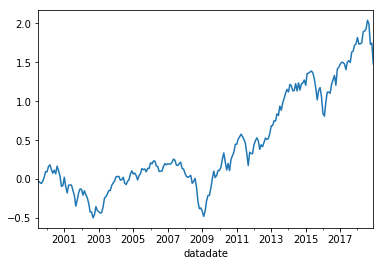

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.097164
2000-12-31   -0.165077
2001-12-31   -0.045893
2002-12-31   -0.318500
2003-12-31    0.641929
2004-12-31    0.130965
2005-12-31    0.027728
2006-12-31    0.040142
2007-12-31   -0.045176
2008-12-31   -0.443108
2009-12-31    0.766595
2010-12-31    0.302745
2011-12-31   -0.082804
2012-12-31    0.193819
2013-12-31    0.358779
2014-12-31    0.055961
2015-12-31   -0.096657
2016-12-31    0.186273
2017-12-31    0.123770
2018-12-31   -0.093887
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     656.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.93e-124
Time:                        14:11:00   Log-Likelihood:                 612.66
No. Observations:                 234   AIC:                            -1215.
Df Residuals:                     229   BIC:                            -1198.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      1.743      0.083      -0.000       0.005
mktrf          1.0460      0.033     31.436      0.000       0.980       1.112
me             0.2854      0.039      7.375      0.000       0.209       0.362
ia             0.2052      0.059      3.488      0.001       0.089       0.321
roe           -0.5487      0.050    -10.897      0.000      -0.648      -0.449
==============================================================================
Omnibus:                       47.765   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.694
Skew:                           0.768   Prob(JB):                     9.55e-40
Kurtosis:                       7.009   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     335.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.73e-94
Time:                        14:11:00   Log-Likelihood:                 612.66
No. Observations:                 234   AIC:                            -1215.
Df Residuals:                     229   BIC:                            -1198.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      1.641      0.101      -0.000       0.005
mktrf          1.0460      0.047     22.034      0.000       0.953       1.139
me             0.2854      0.106      2.689      0.007       0.077       0.493
ia             0.2052      0.122      1.686      0.092      -0.033       0.444
roe           -0.5487      0.097     -5.679      0.000      -0.738      -0.359
==============================================================================
Omnibus:                       47.765   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.694
Skew:                           0.768   Prob(JB):                     9.55e-40
Kurtosis:                       7.009   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     301.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.98e-90
Time:                        14:11:00   Log-Likelihood:                 612.66
No. Observations:                 234   AIC:                            -1215.
Df Residuals:                     229   BIC:                            -1198.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      1.593      0.111      -0.000       0.005
mktrf          1.0460      0.052     20.222      0.000       0.945       1.147
me             0.2854      0.116      2.465      0.014       0.058       0.512
ia             0.2052      0.118      1.735      0.083      -0.027       0.437
roe           -0.5487      0.107     -5.113      0.000      -0.759      -0.338
==============================================================================
Omnibus:                       47.765   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.694
Skew:                           0.768   Prob(JB):                     9.55e-40
Kurtosis:                       7.009   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     423.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.37e-113
Time:                        14:11:00   Log-Likelihood:                 590.19
No. Observations:                 234   AIC:                            -1168.
Df Residuals:                     228   BIC:                            -1148.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      0.879      0.380      -0.001       0.004
mktrf          1.1102      0.037     30.187      0.000       1.038       1.183
smb            0.3630      0.049      7.481      0.000       0.267       0.459
hml            0.2502      0.057      4.372      0.000       0.137       0.363
rmw           -0.3878      0.065     -5.994      0.000      -0.515      -0.260
cma           -0.0464      0.082     -0.564      0.573      -0.208       0.116
==============================================================================
Omnibus:                       67.921   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              248.074
Skew:                           1.154   Prob(JB):                     1.35e-54
Kurtosis:                       7.485   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     237.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.23e-88
Time:                        14:11:00   Log-Likelihood:                 590.19
No. Observations:                 234   AIC:                            -1168.
Df Residuals:                     228   BIC:                            -1148.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.750      0.454      -0.002       0.004
mktrf          1.1102      0.040     27.524      0.000       1.031       1.189
smb            0.3630      0.104      3.492      0.000       0.159       0.567
hml            0.2502      0.098      2.556      0.011       0.058       0.442
rmw           -0.3878      0.114     -3.389      0.001      -0.612      -0.164
cma           -0.0464      0.163     -0.284      0.776      -0.366       0.274
==============================================================================
Omnibus:                       67.921   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              248.074
Skew:                           1.154   Prob(JB):                     1.35e-54
Kurtosis:                       7.485   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     246.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.87e-90
Time:                        14:11:00   Log-Likelihood:                 590.19
No. Observations:                 234   AIC:                            -1168.
Df Residuals:                     228   BIC:                            -1148.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.680      0.496      -0.002       0.005
mktrf          1.1102      0.041     27.081      0.000       1.030       1.191
smb            0.3630      0.104      3.482      0.000       0.159       0.567
hml            0.2502      0.081      3.092      0.002       0.092       0.409
rmw           -0.3878      0.123     -3.140      0.002      -0.630      -0.146
cma           -0.0464      0.164     -0.283      0.777      -0.368       0.275
==============================================================================
Omnibus:                       67.921   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              248.074
Skew:                           1.154   Prob(JB):                     1.35e-54
Kurtosis:                       7.485   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     828.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.75e-135
Time:                        14:11:00   Log-Likelihood:                 638.01
No. Observations:                 234   AIC:                            -1266.
Df Residuals:                     229   BIC:                            -1249.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.879      0.380      -0.001       0.003
mktrf          1.0698      0.027     38.918      0.000       1.016       1.124
smb            0.5723      0.034     16.678      0.000       0.505       0.640
hml            0.1229      0.034      3.604      0.000       0.056       0.190
umd           -0.2969      0.022    -13.275      0.000      -0.341      -0.253
==============================================================================
Omnibus:                       34.762   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.811
Skew:                           0.686   Prob(JB):                     1.72e-18
Kurtosis:                       5.551   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     413.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.84e-103
Time:                        14:11:00   Log-Likelihood:                 638.01
No. Observations:                 234   AIC:                            -1266.
Df Residuals:                     229   BIC:                            -1249.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.830      0.407      -0.001       0.003
mktrf          1.0698      0.030     35.879      0.000       1.011       1.128
smb            0.5723      0.062      9.249      0.000       0.451       0.694
hml            0.1229      0.049      2.513      0.012       0.027       0.219
umd           -0.2969      0.040     -7.487      0.000      -0.375      -0.219
==============================================================================
Omnibus:                       34.762   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.811
Skew:                           0.686   Prob(JB):                     1.72e-18
Kurtosis:                       5.551   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     351.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.87e-96
Time:                        14:11:01   Log-Likelihood:                 638.01
No. Observations:                 234   AIC:                            -1266.
Df Residuals:                     229   BIC:                            -1249.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.900      0.368      -0.001       0.003
mktrf          1.0698      0.033     32.686      0.000       1.006       1.134
smb            0.5723      0.069      8.270      0.000       0.437       0.708
hml            0.1229      0.045      2.738      0.006       0.035       0.211
umd           -0.2969      0.039     -7.664      0.000      -0.373      -0.221
==============================================================================
Omnibus:                       34.762   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.811
Skew:                           0.686   Prob(JB):                     1.72e-18
Kurtosis:                       5.551   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     315.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.22e-61
Time:                        14:11:01   Log-Likelihood:                 296.12
No. Observations:                 120   AIC:                            -582.2
Df Residuals:                     115   BIC:                            -568.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.002      1.768      0.080      -0.000       0.008
mktrf          1.0470      0.054     19.384      0.000       0.940       1.154
me             0.1735      0.053      3.251      0.002       0.068       0.279
ia             0.1985      0.084      2.377      0.019       0.033       0.364
roe           -0.5674      0.074     -7.674      0.000      -0.714      -0.421
==============================================================================
Omnibus:                       12.219   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               19.165
Skew:                           0.476   Prob(JB):                     6.89e-05
Kurtosis:                       4.710   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     191.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.62e-50
Time:                        14:11:01   Log-Likelihood:                 296.12
No. Observations:                 120   AIC:                            -582.2
Df Residuals:                     115   BIC:                            -568.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.002      1.766      0.077      -0.000       0.007
mktrf          1.0470      0.057     18.486      0.000       0.936       1.158
me             0.1735      0.097      1.779      0.075      -0.018       0.365
ia             0.1985      0.136      1.455      0.146      -0.069       0.466
roe           -0.5674      0.109     -5.218      0.000      -0.781      -0.354
==============================================================================
Omnibus:                       12.219   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               19.165
Skew:                           0.476   Prob(JB):                     6.89e-05
Kurtosis:                       4.710   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     159.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.24e-46
Time:                        14:11:01   Log-Likelihood:                 296.12
No. Observations:                 120   AIC:                            -582.2
Df Residuals:                     115   BIC:                            -568.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.002      1.804      0.071      -0.000       0.007
mktrf          1.0470      0.063     16.658      0.000       0.924       1.170
me             0.1735      0.106      1.636      0.102      -0.034       0.381
ia             0.1985      0.134      1.485      0.138      -0.063       0.461
roe           -0.5674      0.121     -4.676      0.000      -0.805      -0.330
==============================================================================
Omnibus:                       12.219   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               19.165
Skew:                           0.476   Prob(JB):                     6.89e-05
Kurtosis:                       4.710   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     192.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.14e-54
Time:                        14:11:01   Log-Likelihood:                 281.88
No. Observations:                 120   AIC:                            -551.8
Df Residuals:                     114   BIC:                            -535.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      1.439      0.153      -0.001       0.008
mktrf          1.1741      0.064     18.229      0.000       1.047       1.302
smb            0.2665      0.073      3.653      0.000       0.122       0.411
hml            0.1935      0.089      2.165      0.032       0.016       0.371
rmw           -0.3601      0.105     -3.416      0.001      -0.569      -0.151
cma           -0.0100      0.115     -0.086      0.931      -0.239       0.219
==============================================================================
Omnibus:                       28.656   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.416
Skew:                           0.998   Prob(JB):                     5.62e-13
Kurtosis:                       5.702   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     89.01
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.04e-37
Time:                        14:11:01   Log-Likelihood:                 281.88
No. Observations:                 120   AIC:                            -551.8
Df Residuals:                     114   BIC:                            -535.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      1.368      0.171      -0.001       0.008
mktrf          1.1741      0.061     19.286      0.000       1.055       1.293
smb            0.2665      0.126      2.111      0.035       0.019       0.514
hml            0.1935      0.104      1.861      0.063      -0.010       0.397
rmw           -0.3601      0.127     -2.835      0.005      -0.609      -0.111
cma           -0.0100      0.188     -0.053      0.958      -0.379       0.359
==============================================================================
Omnibus:                       28.656   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.416
Skew:                           0.998   Prob(JB):                     5.62e-13
Kurtosis:                       5.702   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     88.06
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.69e-37
Time:                        14:11:01   Log-Likelihood:                 281.88
No. Observations:                 120   AIC:                            -551.8
Df Residuals:                     114   BIC:                            -535.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.003      1.273      0.203      -0.002       0.008
mktrf          1.1741      0.058     20.325      0.000       1.061       1.287
smb            0.2665      0.119      2.233      0.026       0.033       0.500
hml            0.1935      0.091      2.120      0.034       0.015       0.372
rmw           -0.3601      0.134     -2.683      0.007      -0.623      -0.097
cma           -0.0100      0.187     -0.053      0.958      -0.377       0.357
==============================================================================
Omnibus:                       28.656   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.416
Skew:                           0.998   Prob(JB):                     5.62e-13
Kurtosis:                       5.702   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     429.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.86e-68
Time:                        14:11:01   Log-Likelihood:                 313.28
No. Observations:                 120   AIC:                            -616.6
Df Residuals:                     115   BIC:                            -602.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.346      0.181      -0.001       0.006
mktrf          1.0995      0.041     26.658      0.000       1.018       1.181
smb            0.5058      0.047     10.771      0.000       0.413       0.599
hml            0.0701      0.047      1.491      0.139      -0.023       0.163
umd           -0.2964      0.029    -10.220      0.000      -0.354      -0.239
==============================================================================
Omnibus:                        9.820   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               13.359
Skew:                           0.430   Prob(JB):                      0.00126
Kurtosis:                       4.390   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     405.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.23e-67
Time:                        14:11:01   Log-Likelihood:                 313.28
No. Observations:                 120   AIC:                            -616.6
Df Residuals:                     115   BIC:                            -602.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.341      0.180      -0.001       0.006
mktrf          1.0995      0.044     25.158      0.000       1.014       1.185
smb            0.5058      0.065      7.840      0.000       0.379       0.632
hml            0.0701      0.061      1.153      0.249      -0.049       0.189
umd           -0.2964      0.044     -6.803      0.000      -0.382      -0.211
==============================================================================
Omnibus:                        9.820   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               13.359
Skew:                           0.430   Prob(JB):                      0.00126
Kurtosis:                       4.390   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     541.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.41e-73
Time:                        14:11:01   Log-Likelihood:                 313.28
No. Observations:                 120   AIC:                            -616.6
Df Residuals:                     115   BIC:                            -602.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      1.571      0.116      -0.001       0.005
mktrf          1.0995      0.048     22.807      0.000       1.005       1.194
smb            0.5058      0.075      6.729      0.000       0.358       0.653
hml            0.0701      0.064      1.104      0.270      -0.054       0.195
umd           -0.2964      0.041     -7.264      0.000      -0.376      -0.216
==============================================================================
Omnibus:                        9.820   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               13.359
Skew:                           0.430   Prob(JB):                      0.00126
Kurtosis:                       4.390   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     539.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.49e-71
Time:                        14:11:01   Log-Likelihood:                 350.60
No. Observations:                 114   AIC:                            -691.2
Df Residuals:                     109   BIC:                            -677.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      1.879      0.063      -0.000       0.004
mktrf          0.9660      0.034     28.758      0.000       0.899       1.033
me             0.6271      0.052     12.091      0.000       0.524       0.730
ia             0.1648      0.072      2.291      0.024       0.022       0.307
roe           -0.5370      0.063     -8.496      0.000      -0.662      -0.412
==============================================================================
Omnibus:                      107.837   Durbin-Watson:                   1.688
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1802.647
Skew:                           3.021   Prob(JB):                         0.00
Kurtosis:                      21.520   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     402.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.65e-64
Time:                        14:11:01   Log-Likelihood:                 350.60
No. Observations:                 114   AIC:                            -691.2
Df Residuals:                     109   BIC:                            -677.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      1.582      0.114      -0.001       0.005
mktrf          0.9660      0.030     32.662      0.000       0.908       1.024
me             0.6271      0.048     13.078      0.000       0.533       0.721
ia             0.1648      0.078      2.126      0.033       0.013       0.317
roe           -0.5370      0.098     -5.497      0.000      -0.728      -0.346
==============================================================================
Omnibus:                      107.837   Durbin-Watson:                   1.688
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1802.647
Skew:                           3.021   Prob(JB):                         0.00
Kurtosis:                      21.520   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     398.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.64e-64
Time:                        14:11:01   Log-Likelihood:                 350.60
No. Observations:                 114   AIC:                            -691.2
Df Residuals:                     109   BIC:                            -677.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      1.706      0.088      -0.000       0.005
mktrf          0.9660      0.029     33.053      0.000       0.909       1.023
me             0.6271      0.055     11.369      0.000       0.519       0.735
ia             0.1648      0.083      1.995      0.046       0.003       0.327
roe           -0.5370      0.097     -5.520      0.000      -0.728      -0.346
==============================================================================
Omnibus:                      107.837   Durbin-Watson:                   1.688
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1802.647
Skew:                           3.021   Prob(JB):                         0.00
Kurtosis:                      21.520   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     341.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.74e-64
Time:                        14:11:01   Log-Likelihood:                 338.49
No. Observations:                 114   AIC:                            -665.0
Df Residuals:                     108   BIC:                            -648.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.510      0.611      -0.002       0.003
mktrf          1.0015      0.036     27.983      0.000       0.931       1.072
smb            0.6160      0.058     10.602      0.000       0.501       0.731
hml            0.2506      0.074      3.381      0.001       0.104       0.397
rmw           -0.3790      0.091     -4.178      0.000      -0.559      -0.199
cma            0.0182      0.115      0.158      0.875      -0.210       0.246
==============================================================================
Omnibus:                       64.263   Durbin-Watson:                   1.513
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              315.057
Skew:                           1.883   Prob(JB):                     3.86e-69
Kurtosis:                      10.221   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     258.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.43e-58
Time:                        14:11:01   Log-Likelihood:                 338.49
No. Observations:                 114   AIC:                            -665.0
Df Residuals:                     108   BIC:                            -648.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.407      0.684      -0.002       0.004
mktrf          1.0015      0.031     32.719      0.000       0.941       1.061
smb            0.6160      0.055     11.200      0.000       0.508       0.724
hml            0.2506      0.129      1.935      0.053      -0.003       0.504
rmw           -0.3790      0.113     -3.365      0.001      -0.600      -0.158
cma            0.0182      0.108      0.167      0.867      -0.194       0.231
==============================================================================
Omnibus:                       64.263   Durbin-Watson:                   1.513
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              315.057
Skew:                           1.883   Prob(JB):                     3.86e-69
Kurtosis:                      10.221   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     238.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.14e-56
Time:                        14:11:01   Log-Likelihood:                 338.49
No. Observations:                 114   AIC:                            -665.0
Df Residuals:                     108   BIC:                            -648.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.390      0.697      -0.003       0.004
mktrf          1.0015      0.032     31.608      0.000       0.939       1.064
smb            0.6160      0.058     10.570      0.000       0.502       0.730
hml            0.2506      0.117      2.148      0.032       0.022       0.479
rmw           -0.3790      0.106     -3.575      0.000      -0.587      -0.171
cma            0.0182      0.100      0.181      0.856      -0.178       0.215
==============================================================================
Omnibus:                       64.263   Durbin-Watson:                   1.513
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              315.057
Skew:                           1.883   Prob(JB):                     3.86e-69
Kurtosis:                      10.221   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     451.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.02e-67
Time:                        14:11:01   Log-Likelihood:                 340.89
No. Observations:                 114   AIC:                            -671.8
Df Residuals:                     109   BIC:                            -658.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.553      0.581      -0.002       0.003
mktrf          1.0031      0.035     28.938      0.000       0.934       1.072
smb            0.7166      0.054     13.258      0.000       0.609       0.824
hml            0.2615      0.056      4.698      0.000       0.151       0.372
umd           -0.2059      0.042     -4.904      0.000      -0.289      -0.123
==============================================================================
Omnibus:                       53.905   Durbin-Watson:                   1.664
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              275.918
Skew:                           1.486   Prob(JB):                     1.22e-60
Kurtosis:                      10.018   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     337.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.96e-60
Time:                        14:11:01   Log-Likelihood:                 340.89
No. Observations:                 114   AIC:                            -671.8
Df Residuals:                     109   BIC:                            -658.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.446      0.656      -0.002       0.004
mktrf          1.0031      0.034     29.872      0.000       0.937       1.069
smb            0.7166      0.042     17.078      0.000       0.634       0.799
hml            0.2615      0.094      2.792      0.005       0.078       0.445
umd           -0.2059      0.058     -3.530      0.000      -0.320      -0.092
==============================================================================
Omnibus:                       53.905   Durbin-Watson:                   1.664
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              275.918
Skew:                           1.486   Prob(JB):                     1.22e-60
Kurtosis:                      10.018   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     328.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.99e-60
Time:                        14:11:01   Log-Likelihood:                 340.89
No. Observations:                 114   AIC:                            -671.8
Df Residuals:                     109   BIC:                            -658.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.422      0.673      -0.002       0.004
mktrf          1.0031      0.033     30.362      0.000       0.938       1.068
smb            0.7166      0.042     16.983      0.000       0.634       0.799
hml            0.2615      0.096      2.737      0.006       0.074       0.449
umd           -0.2059      0.055     -3.752      0.000      -0.313      -0.098
==============================================================================
Omnibus:                       53.905   Durbin-Watson:                   1.664
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              275.918
Skew:                           1.486   Prob(JB):                     1.22e-60
Kurtosis:                      10.018   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""